### Null-distribution for number of cell categories

Here we:
* Assume responsiveness only occurs by chance (alpha = 0.05)
* Assign cells randomly to be responsive or not to given condition
* Categorize into classes
* Do this a number of times
* How many cells do we expect to be classified as 'rewarded' by chance alone?
* Compute p-values for classification of cell

In [1]:
cd /home/blansdel/projects/schwarz/decoder

/home/blansdel/projects/schwarz/decoder


In [2]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import combinations, product
from collections import defaultdict
from collections import Counter
from scipy.stats import chi2_contingency
from sklearn.metrics import confusion_matrix 

from src.lib import *

In [3]:

sessions = [2, 6, 7, 9]
str_sessions = [str(x) for x in sessions]
events = ['ReSpout_pos', 'ReSpout_neg', \
       'UnSpout_pos', 'UnSpout_neg', 'ReMid_pos', 'ReMid_neg', 'UnMid_pos', \
       'UnMid_neg']
       
fn_in = './data/input/explore2.csv'
df = pd.read_csv(fn_in)
conditions = df.treatment.unique()
n_cond = len(conditions)
n_animals = 3

In [5]:
def classify_cell(df, idx):
    row = df.iloc[idx]
    tp = 'Non-responsive'
    if ((row.ReSpout_pos == True) or (row.ReSpout_neg == True) or (row.ReMid_pos == True) or (row.ReMid_neg == True)) and \
        ((row.UnSpout_pos == False) or (row.UnSpout_neg == False) or (row.UnMid_pos == False) or (row.UnMid_neg == False)):
        tp = 'Rewarded'
    if ((row.UnSpout_pos == True) or (row.UnSpout_neg == True) or (row.UnMid_pos == True) or (row.UnMid_neg == True)) and \
        ((row.ReSpout_pos == False) or (row.ReSpout_neg == False) or (row.ReMid_pos == False) or (row.ReMid_neg == False)):
        tp = 'UnRewarded'

    return tp

In [6]:
stats = df.groupby(['treatment', 'Animal', 'Session', 'CellType']).count()['recording']
stats = stats.reset_index()
treatments = conditions
for treat in treatments:
    animals = stats.loc[stats.treatment == treat, "Animal"].unique()
    for animal in animals:
        for session in sessions:
            this_cell_sum = stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "recording"].sum()
            stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "cell_prob"] = \
                stats.loc[(stats.treatment == treat) & (stats.Animal == animal) & (stats.Session == session), "recording"]/this_cell_sum

In [7]:
alpha = 0.05
df_null = df.copy()
N_reps = 100

# non_responsive_props = defaultdict(dict)
# rewarded_props = defaultdict(dict)
# unrewarded_props = defaultdict(dict)
sample_cols = ['ReSpout_pos','ReSpout_neg','UnSpout_pos','UnSpout_neg',	'ReMid_pos', 'ReMid_neg', 'UnMid_pos', 'UnMid_neg']

resampling_results = pd.DataFrame(columns = ['treatment', 'animal', 'session', 'celltype', 'p-val'])

for treat in conditions:
    animals = df_null.loc[df_null.treatment == treat, "Animal"].unique()
    for animal in animals:
        for session in sessions:
            df_null_cond = df_null.loc[(df_null['treatment'] == treat) & (df_null['Animal'] == animal) & (df_null['Session'] == session)]
            nr = []
            rr = []
            ur = []
            for rep in range(N_reps):
                df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
                for idx in range(len(df_null_cond)):
                    ct = classify_cell(df_null_cond, idx)
                    df_null_cond.iloc[idx,-1] = ct
                cts = df_null_cond.CellType.value_counts()/len(df_null_cond)
                nr.append(cts['Non-responsive'])
                rr.append(cts['Rewarded'])
                ur.append(cts['UnRewarded'])
            try:
                p_nr = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Non-responsive'), 'cell_prob'].values[0]
                p_rr = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Rewarded'), 'cell_prob'].values[0]
                p_ur = stats.loc[(stats['treatment'] == treat) & (stats['Animal'] == animal) & (stats['Session'] == session) & (stats['CellType'] == 'Unrewarded'), 'cell_prob'].values[0]
            except IndexError: 
                print("Skipping", treat, animal, session)
                continue
            pval_nr = sum(p_nr < np.array(nr))/N_reps
            pval_ur = sum(p_ur < np.array(ur))/N_reps
            pval_rr = sum(p_rr < np.array(rr))/N_reps
            newrow1 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['Non-responsive'], 'p-val': [pval_nr]})
            newrow2 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['Rewarded'], 'p-val': [pval_rr]})
            newrow3 = pd.DataFrame({'treatment': [treat], 'animal': [animal], 'session': [session], 'celltype': ['UnRewarded'], 'p-val': [pval_ur]})
            resampling_results = pd.concat([resampling_results, newrow1, newrow2, newrow3], axis = 0)

/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Skipping Clonidine 83 6


/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Skipping Idazoxan 4 6


/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_null_cond.loc[:,sample_cols] = np.random.random(df_null_cond.loc[:,sample_cols].shape)<alpha
/tmp/ipykernel_3246631/2712826441.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

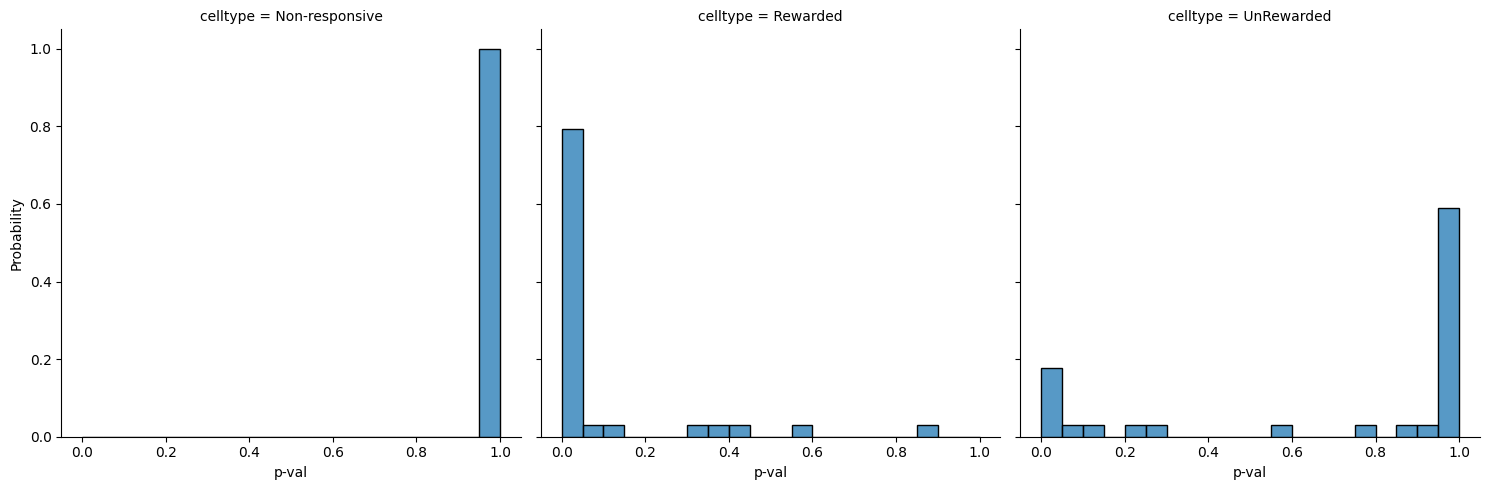

In [8]:
sns.displot(resampling_results, x = 'p-val', col = 'celltype', bins = 20, stat = 'probability', common_norm = False)

Observed, many *more* rewarded cells than expected based on alpha level. Not the same overabundance in unrewarded cells. Gives a way to interpret the number of responsive cells as high or not.

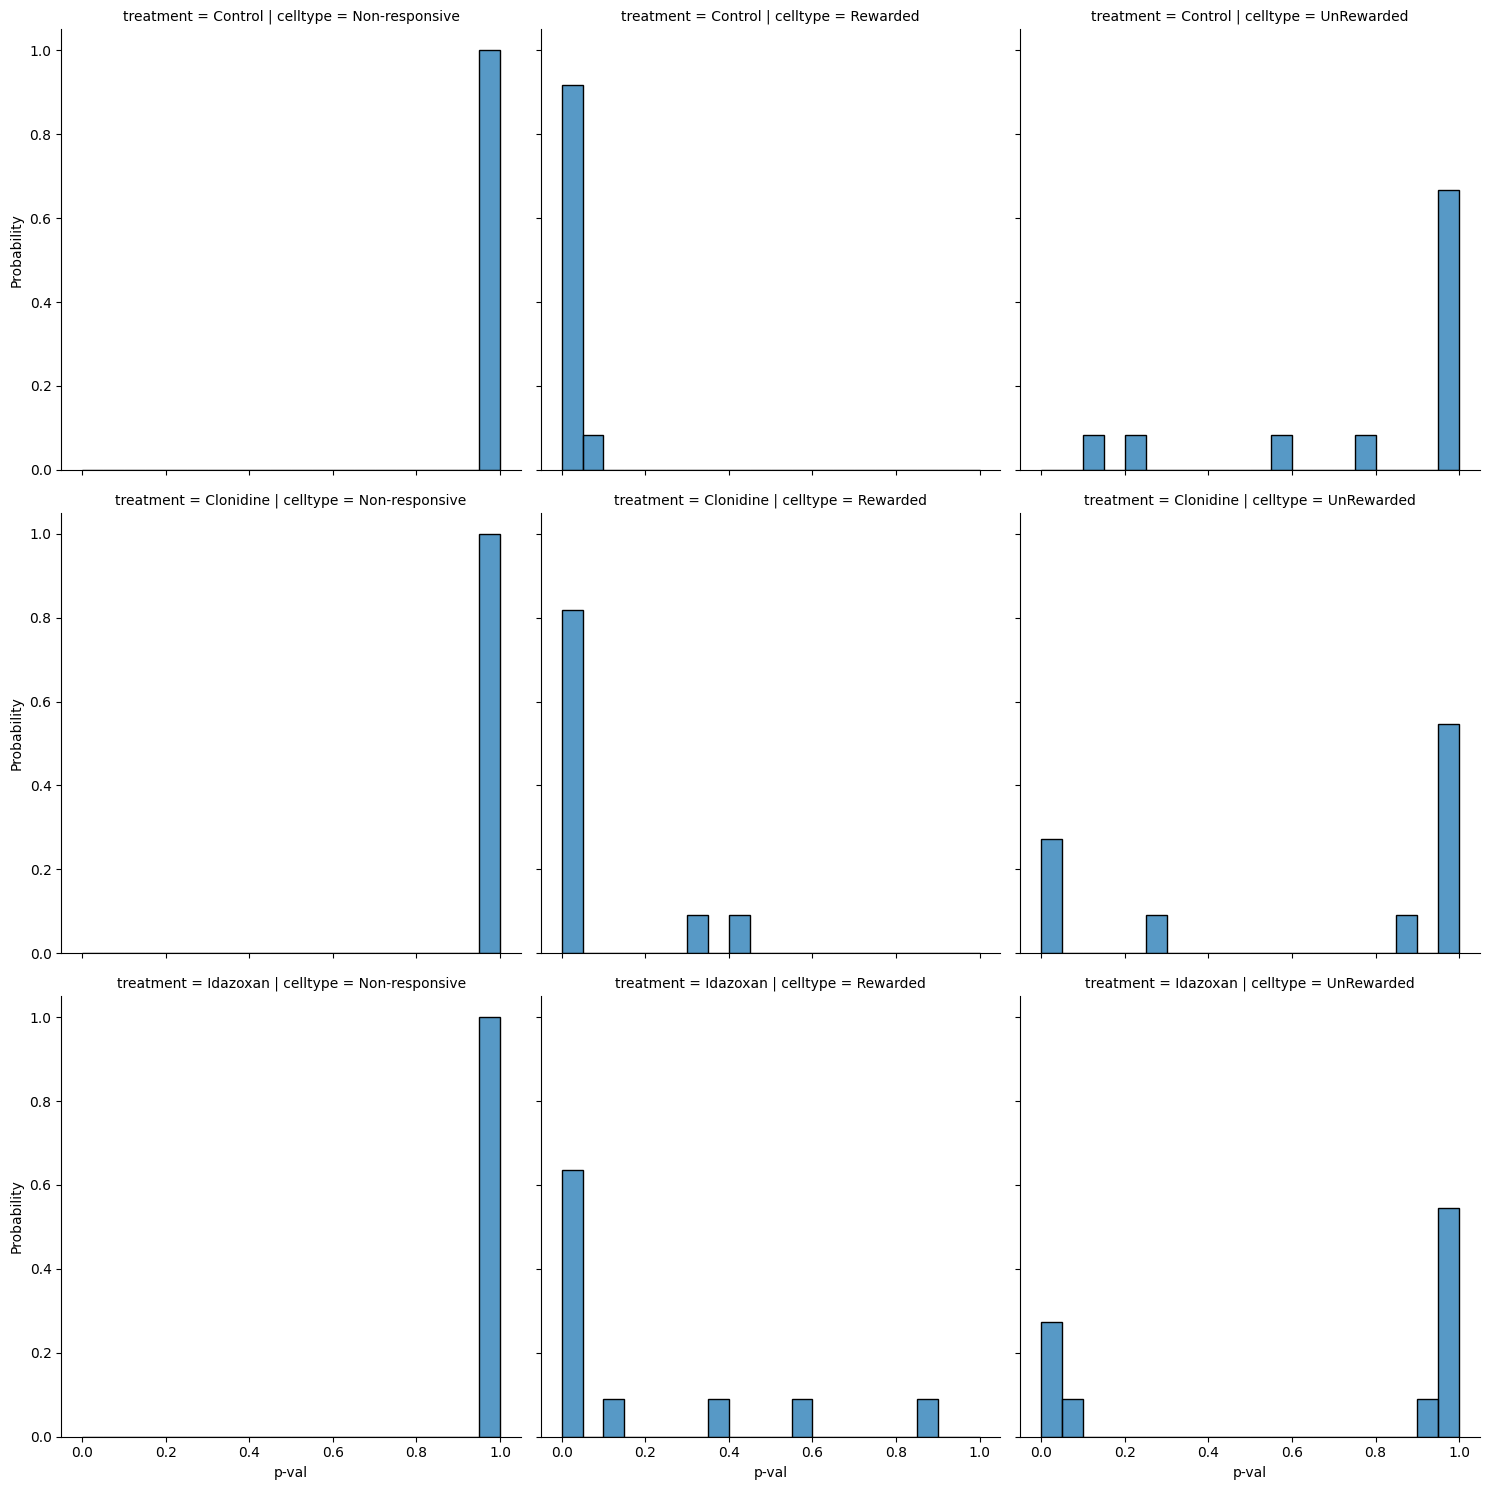

In [9]:
sns.displot(resampling_results, x = 'p-val', col = 'celltype', row = 'treatment', bins = 20, stat = 'probability', common_norm = False)

Baseline probabilities or two cell types, expected purely by simple definition

Expected counts for non-responsive
`(1-alpha)^8`

Expected counts for rewarded:
`1-(1-alpha)^4`

Expected counts for unrewarded:
`1-(1-alpha)^4`

In [10]:
non_responsive_prob = (1-alpha)**8
rewarded_prob = 1-(1-alpha)**4

In [12]:
print("Expected rewarded cell proportion by chance alone:", rewarded_prob)
print("Expected unrewarded cell proportion by chance alone:", rewarded_prob)
print("Expected non-responsive cell proportion by chance alone:", non_responsive_prob)

Expected rewarded cell proportion by chance alone: 0.18549375000000012
Expected unrewarded cell proportion by chance alone: 0.18549375000000012
Expected non-responsive cell proportion by chance alone: 0.6634204312890623
